In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.display import display, HTML

import numpy as np 
import pandas as pd
import cv2
import math

import os
from pathlib import Path

import time
from datetime import datetime

from histogram import *
from imagereader import *
from histogramStatistics import *
from smoothHistogram import *
matchHist=None

In [3]:
def channelStat(im): 
    if im.ndim==3 and im.shape[2]==3: 
        return np.mean(im[:,:,0]), np.mean(im[:,:,1]), np.mean(im[:,:,2]), \
               np.std(im[:,:,0]),  np.std(im[:,:,1]),  np.std(im[:,:,2] ) 
    else: 
        return np.mean(im), np.std(im)
    
def genEqualization(pathTrg, reader, writer, files, nbCommon, eqc, vmin, vmax, matchHistogram=None):
    filenames, testOrTrain, hSrcAll,hTrgAll, chStatSrc, chStatTrg = [],[],[],[],[],[]
    middelBins = None
    for f in files:
        testOrTrain.append( f.parts[nbCommon] )

        fTrg = pathTrg.joinpath(*f.parts[nbCommon:])
    
        imSrc= ImageColors(reader.open(f), eqc)    
        hSrc  = Histogram.fromBinIntervals(histType,imSrc.V.flatten(),vmin,vmax,nBins)
        
        imTrg = ImageColors(imSrc.im.copy(), eqc)    
        imTrg.V = hSrc.equalize(imTrg.V) if matchHistogram is None else hSrc.equalize_t(imTrg.V,matchHistogram)
            
        writer(fTrg,imTrg.im)
        
        if middelBins is None: middelBins = hSrc.middelBins
        
        filenames.append(Path(f.stem).name)
        hSrcAll.append(hSrc.hist)        
        chStatSrc.append(channelStat(imSrc.im))
        
        hTrg  = Histogram.fromBinIntervals(histType,imTrg.V.flatten(),vmin,vmax,nBins)
        hTrgAll.append(hTrg.hist)
        chStatTrg.append(channelStat(imTrg.im))
        
    cols        =  list( map(str,np.round(middelBins,6)) )
    dfSrcAll    = pd.DataFrame(index=filenames, data = np.asarray(hSrcAll), columns=cols ) 
    dfSrcAll.insert(0,"testOrTrain","", allow_duplicates=True)
    dfSrcAll.testOrTrain = np.asarray(testOrTrain)

    dfTrgAll    = pd.DataFrame(index=filenames, data = np.asarray(hTrgAll), columns=cols ) 
    dfTrgAll.insert(0,"testOrTrain",testOrTrain)
    dfTrgAll.testOrTrain = np.asarray(testOrTrain)
    
    columns=["rMean","gMean","bMean","rSD","gSD","bSD"] if np.asarray(chStatSrc).shape[1]==3 else ["mean_","sd_"]
    dfchStatSrc = pd.DataFrame(index=filenames, data = np.asarray(chStatSrc), columns=columns ) 
    dfchStatTrg = pd.DataFrame(index=filenames, data = np.asarray(chStatTrg), columns=dfchStatSrc.columns ) 
    return filenames, dfSrcAll,dfTrgAll,dfchStatSrc,dfchStatTrg

def saveHistograms(path, filenames, bins, dfh):
    #cols   = np.round(bins,6)
    #dfh    = pd.DataFrame(index=filenames, data = np.asarray(hl), columns=cols ) 
    dfh.to_csv(path / "histograms.csv" )
    
    mHist  = dfh.mean(axis=0).values
    sdHist = dfh.std(axis=0).values
    dfhm   = pd.DataFrame( data = np.stack([bins, mHist, sdHist],axis=-1), columns=["bins", "mean_","std_"] ) 
    dfhm.to_csv(path / "histograms-mean-std.csv" )
    return dfhm

def saveChannelStats( path, dfChStat ):
    dfChStat.to_csv(path / "channelstats.csv" )
    dfm   = pd.DataFrame( columns=dfChStat.columns ) 
    dfm.loc[0] = dfChStat.mean(axis=0).values
    dfm.to_csv(path / "channelstats means.csv", index=False )
    return dfm

def genSaveStats( path, bins ):
    dh = pd.read_csv(path/"histograms.csv", index_col=0)
    dh.drop("testOrTrain",axis=1,inplace=True)
    ds = calcStatistics(bins, dh)
    ds.to_csv(path/"histogram_statistics.csv" )    
    return ds

[PosixPath('../../mammography-data/mammography-dogscats-match-equalization-BINS-CHX'), PosixPath('../../mammography-data/.DS_Store'), PosixPath('../../mammography-data/converted_images')]


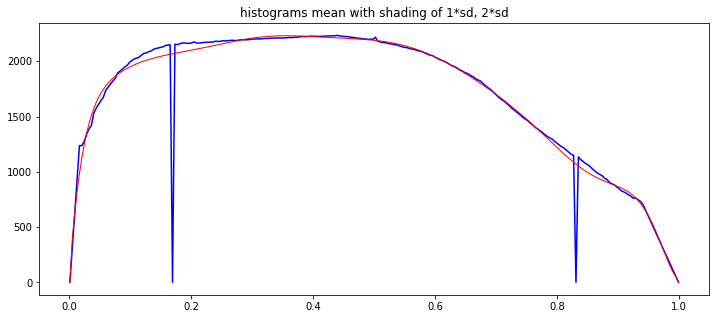

In [4]:
#configuration for equalisation of mammograhies
eqc      = EQC.CHX
histType = HISTOGRAMTYPE.BINS
vmin     = 1/255.0
vmax     = 1. - vmin
nBins    = 256
commonPath = Path("../../mammography-data/")
print(list(commonPath.iterdir()))
pathSrc    = commonPath / "converted_images"
files      = list( pathSrc.glob("**/xray_images/*.png") )
pathTrg    = commonPath / f"mammography-dogscats-match-equalization-{histType.name}-{eqc.name}"
reader     = ImageReader(outChannels=1)
def writer(file,im):
    file.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(file), (im*65535. + 0.5).astype(np.uint16))

dfhists = pd.read_csv("../../fastai-data/data/dogscats/smooth_histogram.csv", index_col=0 )
plotSmoothHistogram( dfhists )

matchHist = Histogram(dfhists.hist_smoothed,vmin=0.,vmax=1.)


In [5]:
def printHist(histType, h):
    print(f"Hist {histType} len:{len(h.middelBins)}: \nbins", h.middelBins, "\nhist:", h.hist, "\ncdf:", h.cdf)   

print(f"Source dataset: {pathSrc}  with {len(files)} files\ntarget dataset: {pathTrg}")
nbCommon = len(commonPath.parts)+1

%time filenames, dfSrcAll, dfTrgAll,dfChStatSrc,dfChStatTrg = \
        genEqualization(pathTrg, reader, writer, files, nbCommon, eqc, vmin, vmax, matchHist)
bins = np.linspace(vmin,vmax,nBins)

dfSrcAll.head()
dfSrcAll.groupby("testOrTrain").count()

Source dataset: ../../mammography-data/converted_images  with 3101 files
target dataset: ../../mammography-data/mammography-dogscats-match-equalization-BINS-CHX
CPU times: user 3h 18min 10s, sys: 6min 59s, total: 3h 25min 9s
Wall time: 1h 5min 11s


,0.003922,0.007812,0.011703,0.015594,0.019485,0.023376,0.027266,0.031157,0.035048,0.038939,...,0.961061,0.964952,0.968843,0.972734,0.976624,0.980515,0.984406,0.988297,0.992188,0.996078
testOrTrain,,,,,,,,,,,,,,,,,,,,,
test,645,645,645,645,645,645,645,645,645,645,...,645,645,645,645,645,645,645,645,645,645
train,2456,2456,2456,2456,2456,2456,2456,2456,2456,2456,...,2456,2456,2456,2456,2456,2456,2456,2456,2456,2456


In [6]:
dfSrcMSD         = saveHistograms(pathSrc, filenames, bins, dfSrcAll)
dfChStatMeansSrc = saveChannelStats(pathSrc, dfChStatSrc)
dStatSrc         = genSaveStats(pathSrc, bins)

dfTrgMSD         = saveHistograms(pathTrg, filenames, bins, dfTrgAll)
dfChStatMeansTrg = saveChannelStats(pathTrg, dfChStatTrg)
dStatTrg         = genSaveStats(pathTrg, bins)

print("dfChStatMeansSrc")
display(dfChStatMeansSrc)
print("\ndfChStatMeansTrg")
display(dfChStatMeansTrg)

dfChStatMeansSrc


,mean_,sd_
0,0.366119,0.263589



dfChStatMeansTrg


,mean_,sd_
0,0.341503,0.292877


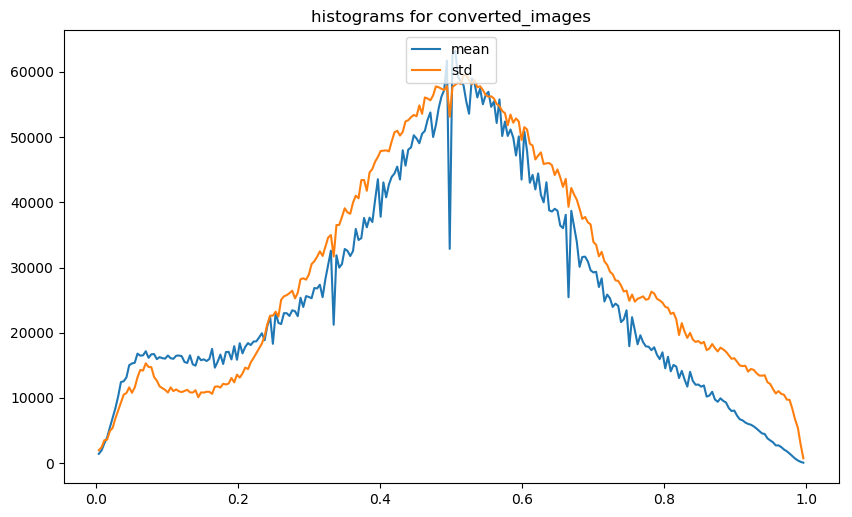

In [7]:
import matplotlib.pyplot as plt 
def plotmeanstd(title, bins, mean, std):
    fig,axes = plt.subplots(nrows=1, ncols=1, figsize = (10,6), dpi=100 )
    axes.set_title(title)
    axes.plot(bins, mean, label="mean" )
    axes.plot(bins, std,  label="std"  )

    #plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
    plt.legend(loc='upper center')

plotmeanstd(f"histograms for {pathSrc.stem}", dfSrcMSD.bins.values, dfSrcMSD.mean_.values, dfSrcMSD.std_.values)

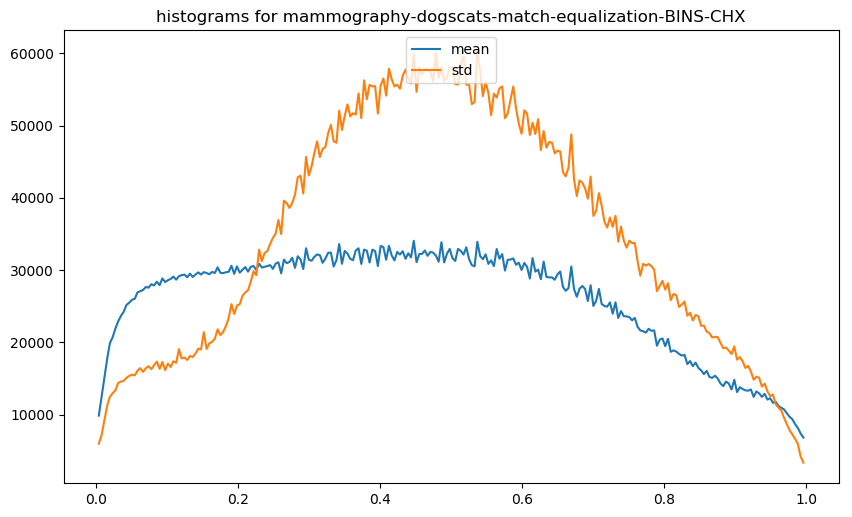

In [8]:
plotmeanstd(f"histograms for {pathTrg.stem}", dfTrgMSD.bins.values, dfTrgMSD.mean_.values, dfTrgMSD.std_.values)

,bins,histMean,histSD,hist_smoothed,hist_no_outliers,histSD_no_outliers
0,0.003922,1425.435666,1978.771039,0.000000,0.000000,0.000000
1,0.007812,1961.101258,2436.461704,1736.121652,1732.317639,1350.102368
2,0.011703,3027.412448,3513.150266,3327.943515,3464.635279,2700.204736
3,0.015594,3941.993228,3597.710905,4895.944211,5196.952918,4050.307104
4,0.019485,5472.075460,4926.867327,6410.928064,6929.270558,5400.409472


,bins,histMean,histSD,hist_smoothed,hist_no_outliers,histSD_no_outliers
251,0.980515,1089.008062,8341.114929,853.372198,1192.649855,3595.286596
252,0.984406,703.856820,6700.924548,626.642277,894.487391,2696.464947
253,0.988297,407.916479,5441.103972,484.611514,596.324927,1797.643298
254,0.992188,203.864560,2898.106847,454.237880,298.162464,898.821649
255,0.996078,70.872622,738.432634,0.000000,0.000000,0.000000


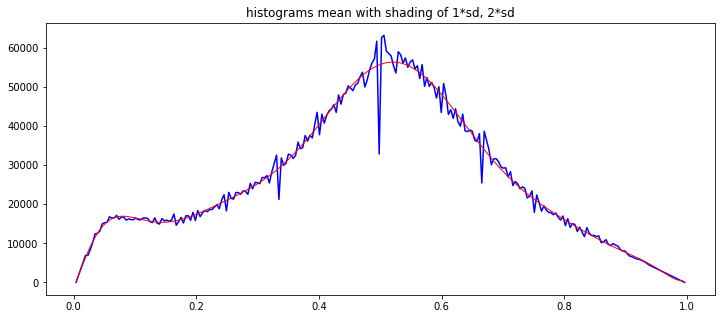

In [9]:
#Calculate a smooth histogram of the source images, The histogram were saved to dfSrcAll
mHist  = dfSrcAll.mean(axis=0).values
sdHist = dfSrcAll.std(axis=0).values
bins   = np.asarray(list(map(float, dfSrcAll.columns[1:])))

ixCutStart=5
ixCutEnd=15
dfSmooth = smoothHistogram( bins, mHist, sdHist, ixCutStart=ixCutStart, ixCutEnd=ixCutEnd )
dfSmooth.insert(1, "histMean", mHist)
dfSmooth.insert(2, "histSD",   sdHist)
dfSmooth.to_csv(pathSrc/"smooth_histogram.csv" )    

display(dfSmooth.head())
display(dfSmooth.tail())
plotSmoothHistogram( dfSmooth )
